# 1. Player's statistics from demos

## 1.1 Map independent stats

In [197]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

# ---------- Prepare data ---------- #

killdemo = os.listdir('../scrape-parse/demo/parse/2022/kills/')
kills = pd.DataFrame()


for i in range(0,400):
    temp = pd.read_csv('../scrape-parse/demo/parse/2022/kills/' + killdemo[i])
    kills = pd.concat([kills, temp])

kills['attackerName'] = kills['attackerName'].str.strip()
kills = kills.reset_index(drop=True)
kills['one'] = 1
# kills = kills.loc[kills['attackerName'].isna() == False]

In [198]:
kills.columns

Index(['Unnamed: 0', 'tick', 'seconds', 'clockTime', 'attackerSteamID',
       'attackerName', 'attackerTeam', 'attackerSide', 'attackerX',
       'attackerY', 'attackerZ', 'attackerViewX', 'attackerViewY',
       'victimSteamID', 'victimName', 'victimTeam', 'victimSide', 'victimX',
       'victimY', 'victimZ', 'victimViewX', 'victimViewY', 'assisterSteamID',
       'assisterName', 'assisterTeam', 'assisterSide', 'isSuicide',
       'isTeamkill', 'isWallbang', 'penetratedObjects', 'isFirstKill',
       'isHeadshot', 'victimBlinded', 'attackerBlinded', 'flashThrowerSteamID',
       'flashThrowerName', 'flashThrowerTeam', 'flashThrowerSide', 'noScope',
       'thruSmoke', 'distance', 'isTrade', 'playerTradedName',
       'playerTradedTeam', 'playerTradedSteamID', 'playerTradedSide', 'weapon',
       'weaponClass', 'roundNum', 'matchID', 'mapName', 'one'],
      dtype='object')

In [200]:
# ----- Players dataset -----
players = pd.DataFrame(kills[['attackerName']])
players['attackerName'] = players['attackerName'].str.strip()
players = players.drop_duplicates(subset=['attackerName']).reset_index(drop=True).sort_values(by=['attackerName'])
players.head(2)

,attackerName
148,ALEX
13,Aleksib


### Stats

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

kdf = kills.copy()

# Player name
kdf['player'] = kdf['attackerName']

# Matches played
mp = kdf[['attackerName','matchID', 'one']].copy()
mp['matchesPlayed'] = mp.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['one'].transform('sum')
kdf = kdf.merge(mp[['attackerName','matchesPlayed']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Kill count
kk = kdf.copy()
kk['killCount'] = kk.groupby(by=['attackerName'])['one'].transform('sum')
kdf = kdf.merge(kk[['attackerName','killCount']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPM - kills per match
kdf['KPM'] = kdf['killCount'] / kdf['matchesPlayed']

# Weighted KPM
kdf['weightedKPM'] = kdf['KPM'] * np.emath.logn(50,kdf['matchesPlayed'] + 1)

# Rounds played
rounds = kdf[['matchID','roundNum']].sort_values(by=['matchID','roundNum']).drop_duplicates(subset=['matchID'],keep='last').rename(columns={'roundNum':'matchRoundsNum'})
kdf = kdf.merge(rounds, on='matchID', how='left')
kdf2 = kdf.copy()
kdf2['roundsPlayed'] = kdf2.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['matchRoundsNum'].transform('sum')
kdf = kdf.merge(kdf2[['attackerName','roundsPlayed']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPR - kills per round
kdf['KPR'] = kdf['killCount'] / kdf['roundsPlayed']

# Headshot %
hs = kdf.copy()
hs['hsCount'] = hs.groupby(by=['attackerName'])['isHeadshot'].transform('sum')
hs['HS%'] = hs['hsCount'] / hs['killCount']
kdf = kdf.merge(hs[['attackerName','hsCount','HS%']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# AWP kills
awp = kdf.copy()
awpTemp = awp.loc[awp['weapon'] == "AWP"].copy()
awpTemp['awpCount'] = awpTemp.groupby(by=['attackerName'])['one'].transform('sum')
kdf = kdf.merge(awpTemp[['attackerName','awpCount']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')
kdf.rename(columns={'awpCount':'killsAWP'}, inplace=True)

# Rifle kills
rifle = kdf.copy()
rifleTemp = rifle.loc[rifle['weaponClass'] == "Rifle"].copy()
rifleTemp['rifleCount'] = rifleTemp.groupby(by=['attackerName'])['one'].transform('sum')
kdf = kdf.merge(rifleTemp[['attackerName','rifleCount']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')
kdf.rename(columns={'rifleCount':'killsRifle'}, inplace=True)

# Assists
assists = kdf.loc[(kdf['assisterName'] != np.nan) & (kdf['assisterTeam'] == kdf['attackerTeam'])].copy()
assists['AST'] = assists.groupby(by=['attackerName'])['one'].transform('sum')
kdf = kdf.merge(assists[['attackerName','AST']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Deaths
deaths = kdf.copy()
deaths['deathCount'] = deaths.groupby(by=['victimName'])['one'].transform('sum')
kdf = kdf.merge(deaths.rename(columns={'attackerName': 'atkname','victimName':'attackerName'})[['attackerName','deathCount']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# K/D
kdf['K/D'] = kdf['killCount'] / kdf['deathCount']

# APR
kdf['APR'] = kdf['AST'] / kdf['roundsPlayed']

# DPR
kdf['DPR'] = kdf['deathCount'] / kdf['roundsPlayed']

# Player death traded
traded = kdf.loc[kdf['isTrade'] == True].copy()
traded['tradedCount'] = traded.groupby(by=['playerTradedName'])['one'].transform('sum')
kdf = kdf.merge(traded.rename(columns={'attackerName': 'atkname','playerTradedName':'attackerName'})[['attackerName','tradedCount']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')



kdf.drop_duplicates(subset='attackerName').head(2)[kdf.columns[52:]]

,player,matchesPlayed,killCount,KPM,weightedKPM,matchRoundsNum,roundsPlayed,KPR,hsCount,HS%,killsAWP,killsRifle,AST,deathCount,K/D,APR,DPR,tradedCount
0,cadiaN,42.0,691.0,16.452381,15.818081,30,1126.0,0.613677,194.0,0.280753,294.0,495.0,137.0,705.0,0.980142,0.121670,0.626110,130.0
1,rain,67.0,1179.0,17.597015,18.980139,30,1774.0,0.664600,612.0,0.519084,2.0,936.0,209.0,475.0,2.482105,0.117813,0.267756,86.0


In [216]:
kdf.loc[kdf['playerTradedName'] == "rain"]

,Unnamed: 0,tick,seconds,clockTime,attackerSteamID,attackerName,attackerTeam,attackerSide,attackerX,attackerY,attackerZ,attackerViewX,attackerViewY,victimSteamID,victimName,victimTeam,victimSide,victimX,victimY,victimZ,victimViewX,victimViewY,assisterSteamID,assisterName,assisterTeam,assisterSide,isSuicide,isTeamkill,isWallbang,penetratedObjects,isFirstKill,isHeadshot,victimBlinded,attackerBlinded,flashThrowerSteamID,flashThrowerName,flashThrowerTeam,flashThrowerSide,noScope,thruSmoke,distance,isTrade,playerTradedName,playerTradedTeam,playerTradedSteamID,playerTradedSide,weapon,weaponClass,roundNum,matchID,mapName,one,player,matchesPlayed,killCount,KPM,weightedKPM,matchRoundsNum,roundsPlayed,KPR,hsCount,HS%,killsAWP,killsRifle,AST,deathCount,K/D,APR,DPR,tradedCount
38456,90,277507,22.554688,01:33,7.656120e+16,Twistzz,FaZe Clan,T,-2629.627441,558.435059,11754.805664,292.933960,3.828735,76561198063336407,Spinx,ENCE,CT,-2557.998047,361.895660,11745.750000,37.655640,359.857178,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,209.381256,True,rain,FaZe Clan,7.656120e+16,T,Glock-18,Pistols,16,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,Twistzz,67.0,1223.0,18.253731,19.688473,27,1774.0,0.689402,694.0,0.567457,18.0,974.0,221.0,1098.0,1.113843,0.124577,0.618940,231.0
38496,130,368409,21.281250,01:34,7.656120e+16,broky,FaZe Clan,T,-799.106323,-1213.763550,11648.031250,11.640015,357.286377,76561198050922008,hades,ENCE,CT,-206.951538,-1090.156616,11776.031250,192.343140,15.441284,NaN,NaN,NaN,NaN,False,False,False,0,False,False,False,False,NaN,NaN,NaN,NaN,False,False,618.312189,True,rain,FaZe Clan,7.656120e+16,T,AK-47,Rifle,22,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,broky,67.0,1321.0,19.716418,21.266127,27,1774.0,0.744645,405.0,0.306586,632.0,1051.0,274.0,405.0,3.261728,0.154453,0.228298,88.0
38506,140,381448,70.406250,00:45,7.656120e+16,karrigan,FaZe Clan,T,-2609.054443,557.933411,11752.019531,88.264160,359.478149,76561198041416993,dycha,ENCE,CT,-2582.085449,1047.123047,11750.538086,267.929077,2.005005,7.656120e+16,Twistzz,FaZe Clan,T,False,False,False,0,False,False,False,False,NaN,NaN,NaN,NaN,False,False,489.934711,True,rain,FaZe Clan,7.656120e+16,T,AK-47,Rifle,23,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,karrigan,67.0,957.0,14.283582,15.406271,27,1774.0,0.539459,475.0,0.496343,15.0,689.0,174.0,1237.0,0.773646,0.098083,0.697294,218.0
38511,145,394178,67.226562,00:48,7.656120e+16,broky,FaZe Clan,T,-2499.149902,-205.276215,11706.031250,67.159424,0.791016,76561198063336407,Spinx,ENCE,CT,-2260.886963,377.191406,11744.031250,248.291016,7.690430,NaN,NaN,NaN,NaN,False,False,True,1,False,False,False,False,NaN,NaN,NaN,NaN,False,False,630.461543,True,rain,FaZe Clan,7.656120e+16,T,AK-47,Rifle,24,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,broky,67.0,1321.0,19.716418,21.266127,27,1774.0,0.744645,405.0,0.306586,632.0,1051.0,274.0,405.0,3.261728,0.154453,0.228298,88.0
38657,118,304576,94.273438,00:21,7.656120e+16,ropz,FaZe Clan,CT,-2677.944580,892.512939,472.281250,273.136597,3.696899,76561198041416993,dycha,ENCE,T,-2616.021484,-223.655823,432.031250,94.625244,359.143066,7.656120e+16,karrigan,FaZe Clan,CT,False,False,False,0,False,False,False,False,NaN,NaN,NaN,NaN,False,False,1118.609511,True,rain,FaZe Clan,7.656120e+16,CT,M4A1,Rifle,17,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_overpass,1,ropz,67.0,1299.0,19.388060,20.911960,36,1774.0,0.732244,655.0,0.504234,82.0,1065.0,236.0,1042.0,1.246641,0.133033,0.587373,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66897,118,243970,27.390625,00:13,7.656120e+16,ropz,FaZe Clan,T,696.435120,-288.983307,139.711945,44.511108,0.812988,7656119804543330

In [195]:
traded.sort_values(by=['matchID','roundNum','tick'], inplace=True)
traded.loc[(traded['tradedPlayer'] == "rain") & (traded['isTrade'] == True)]

,Unnamed: 0,tick,seconds,clockTime,attackerSteamID,attackerName,attackerTeam,attackerSide,attackerX,attackerY,attackerZ,attackerViewX,attackerViewY,victimSteamID,victimName,victimTeam,victimSide,victimX,victimY,victimZ,victimViewX,victimViewY,assisterSteamID,assisterName,assisterTeam,assisterSide,isSuicide,isTeamkill,isWallbang,penetratedObjects,isFirstKill,isHeadshot,victimBlinded,attackerBlinded,flashThrowerSteamID,flashThrowerName,flashThrowerTeam,flashThrowerSide,noScope,thruSmoke,distance,isTrade,playerTradedName,playerTradedTeam,playerTradedSteamID,playerTradedSide,weapon,weaponClass,roundNum,matchID,mapName,one,player,matchesPlayed,killCount,KPM,weightedKPM,matchRoundsNum,roundsPlayed,KPR,hsCount,HS%,killsAWP,killsRifle,AST,deathCount,K/D,APR,DPR,tradedPlayer
38455,89,277446,22.078125,01:33,7.656120e+16,broky,FaZe Clan,T,-2279.080811,719.781433,11744.031250,279.255981,2.043457,76561198165452027,maden,ENCE,CT,-2206.905029,282.207153,11744.031250,135.543823,359.527588,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,443.486859,True,ropz,FaZe Clan,7.656120e+16,T,Glock-18,Pistols,16,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,broky,67.0,1321.0,19.716418,21.266127,27,1774.0,0.744645,405.0,0.306586,632.0,1051.0,274.0,405.0,3.261728,0.154453,0.228298,rain
38496,130,368409,21.281250,01:34,7.656120e+16,broky,FaZe Clan,T,-799.106323,-1213.763550,11648.031250,11.640015,357.286377,76561198050922008,hades,ENCE,CT,-206.951538,-1090.156616,11776.031250,192.343140,15.441284,NaN,NaN,NaN,NaN,False,False,False,0,False,False,False,False,NaN,NaN,NaN,NaN,False,False,618.312189,True,rain,FaZe Clan,7.656120e+16,T,AK-47,Rifle,22,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,broky,67.0,1321.0,19.716418,21.266127,27,1774.0,0.744645,405.0,0.306586,632.0,1051.0,274.0,405.0,3.261728,0.154453,0.228298,rain
38511,145,394178,67.226562,00:48,7.656120e+16,broky,FaZe Clan,T,-2499.149902,-205.276215,11706.031250,67.159424,0.791016,76561198063336407,Spinx,ENCE,CT,-2260.886963,377.191406,11744.031250,248.291016,7.690430,NaN,NaN,NaN,NaN,False,False,True,1,False,False,False,False,NaN,NaN,NaN,NaN,False,False,630.461543,True,rain,FaZe Clan,7.656120e+16,T,AK-47,Rifle,24,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_vertigo,1,broky,67.0,1321.0,19.716418,21.266127,27,1774.0,0.744645,405.0,0.306586,632.0,1051.0,274.0,405.0,3.261728,0.154453,0.228298,rain
38680,141,342573,23.601562,01:32,7.656120e+16,maden,ENCE,T,-1759.578979,-2390.450928,381.090088,138.691406,356.995239,76561198201620490,broky,FaZe Clan,CT,-2672.834961,-1395.736328,434.282471,223.544312,352.760010,7.656120e+16,dycha,ENCE,T,False,False,False,0,False,False,False,False,NaN,NaN,NaN,NaN,False,False,1351.415203,True,dycha,ENCE,7.656120e+16,T,HE Grenade,Grenade,21,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_overpass,1,maden,30.0,591.0,19.700000,17.292728,36,839.0,0.704410,279.0,0.472081,3.0,455.0,116.0,580.0,1.018966,0.138260,0.691299,rain
38705,166,398053,32.453125,01:23,7.656120e+16,ropz,FaZe Clan,CT,-2241.463867,23.740732,413.485626,268.154297,0.774536,76561197989423065,Snappi,ENCE,T,-2245.581543,-1073.214233,392.899628,88.840942,359.401245,7.656120e+16,broky,FaZe Clan,CT,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,1097.155839,True,broky,FaZe Clan,7.656120e+16,CT,M4A1,Rifle,24,ESL-Pro-League-Season-15-ence-vs-faze-bo5ence-...,de_overpass,1,ropz,67.0,1299.0,19.388060,20.911960,36,1774.0,0.732244,655.0,0.504234,82.0,1065.0,236.0,1042.0,1.246641,0.133033,0.587373,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66957,7,9069,51.140625,01:04,7.656120e+16,broky,FaZe Clan,CT,-2240.781250,-225.334763,-166.736526,68.631592,0.747070,76561198208074320,interz,Cloud

### Weighted KDE plots

In [163]:
kdf[['attackerName','weightedKPM','matchesPlayed','killCount','KPM']].drop_duplicates(subset='attackerName').sort_values(by='weightedKPM', ascending=False).head(20)

,attackerName,weightedKPM,matchesPlayed,killCount,KPM
4010,s1mple,23.479201,52.0,1203.0,23.134615
5,broky,21.266127,67.0,1321.0,19.716418
24,ropz,20.911960,67.0,1299.0,19.388060
1187,m0NESY,20.882125,58.0,1162.0,20.034483
5953,k0nfig,20.623872,50.0,1026.0,20.520000
8869,ZywOo,20.523366,50.0,1021.0,20.420000
5944,blameF,20.456533,44.0,925.0,21.022727
1185,NiKo,20.414883,58.0,1136.0,19.586207
8899,Spinx,19.834538,48.0,957.0,19.937500
3,Twistzz,19.688473,67.0,1223.0,18.253731


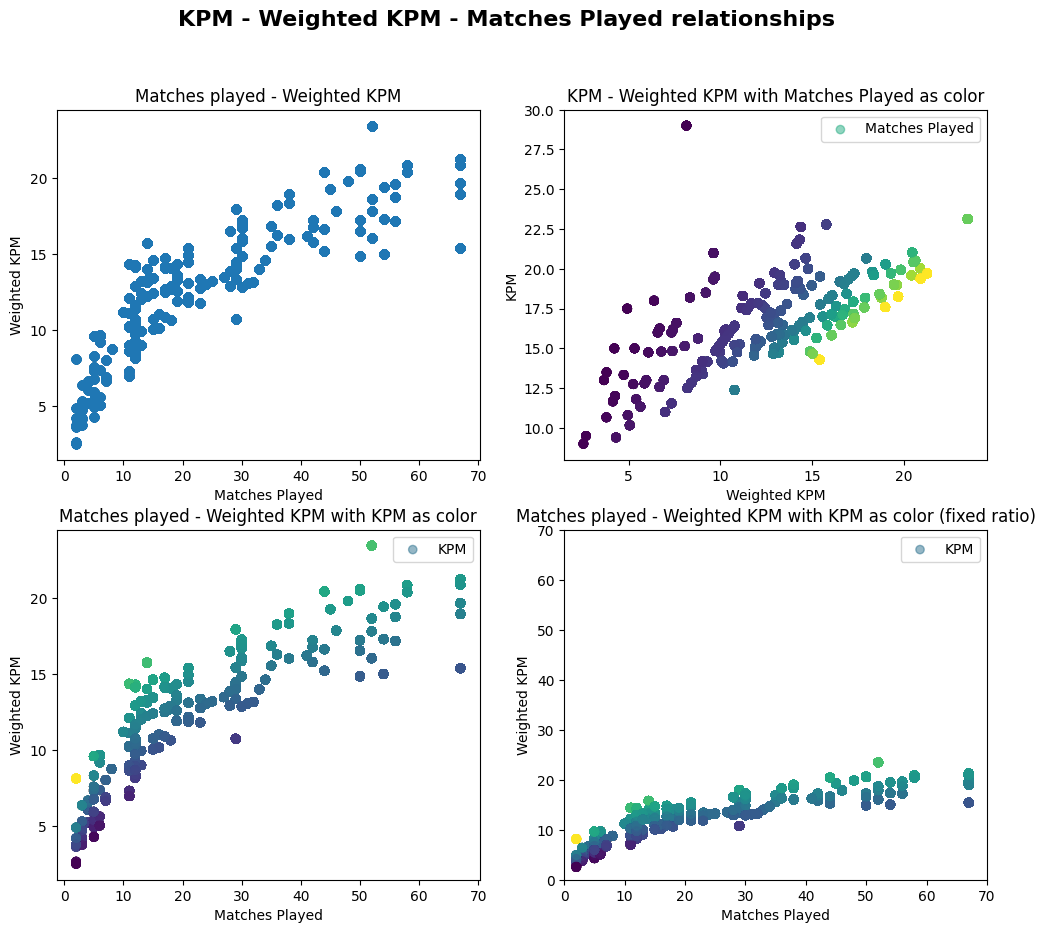

In [167]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('KPM - Weighted KPM - Matches Played relationships', fontsize=16, fontweight='bold')

ax[0,0].set_title('Matches played - Weighted KPM')
ax[0,0].scatter(kdf['matchesPlayed'], kdf['weightedKPM'])
ax[0,0].set_xlabel('Matches Played')
ax[0,0].set_ylabel('Weighted KPM')

ax[0,1].set_title('KPM - Weighted KPM with Matches Played as color')
ax[0,1].scatter(kdf['weightedKPM'], kdf['KPM'], c=kdf['matchesPlayed'], label='Matches Played', cmap='viridis', alpha=0.5)
ax[0,1].set_xlabel('Weighted KPM')
ax[0,1].set_ylabel('KPM')
ax[0,1].legend()

ax[1,0].set_title('Matches played - Weighted KPM with KPM as color')
ax[1,0].scatter(kdf['matchesPlayed'], kdf['weightedKPM'], c=kdf['KPM'], label='KPM', cmap='viridis', alpha=0.5)
ax[1,0].set_xlabel('Matches Played')
ax[1,0].set_ylabel('Weighted KPM')
ax[1,0].legend()

ax[1,1].set_title('Matches played - Weighted KPM with KPM as color (fixed ratio)')
ax[1,1].scatter(kdf['matchesPlayed'], kdf['weightedKPM'], c=kdf['KPM'], label='KPM', cmap='viridis', alpha=0.5)
ax[1,1].set_xlabel('Matches Played')
ax[1,1].set_ylabel('Weighted KPM')
ax[1,1].set_ylim(0,70)
ax[1,1].set_xlim(0,70)
ax[1,1].legend()

In [145]:
kdf.loc[kdf['matchesPlayed'] > 60].drop_duplicates(subset='attackerName')[['attackerName','KPM','weightedKPM','matchesPlayed','killCount']].sort_values(by='weightedKPM', ascending=False).head(20)

,attackerName,KPM,weightedKPM,matchesPlayed,killCount
5,broky,19.716418,24.460085,67.0,1321.0
24,ropz,19.388060,24.052726,67.0,1299.0
3,Twistzz,18.253731,22.645484,67.0,1223.0
1,rain,17.597015,21.830765,67.0,1179.0
9,karrigan,14.283582,17.720137,67.0,957.0


In [147]:
kdf.loc[kdf['weightedKPM'] == kdf['weightedKPM'].max()]['attackerName'].drop_duplicates()

4010    s1mple
Name: attackerName, dtype: object

In [153]:
kdf.loc[kdf['weightedKPM'] > 22.5][['attackerName', 'weightedKPM', 'KPM']].drop_duplicates().sort_values(by='weightedKPM', ascending=False)

,attackerName,weightedKPM,KPM
4010,s1mple,27.005541,23.134615
5,broky,24.460085,19.716418
24,ropz,24.052726,19.388060
1187,m0NESY,24.018410,20.034483
5953,k0nfig,23.721370,20.520000
8869,ZywOo,23.605769,20.420000
5944,blameF,23.528898,21.022727
1185,NiKo,23.480993,19.586207
8899,Spinx,22.813486,19.937500
3,Twistzz,22.645484,18.253731


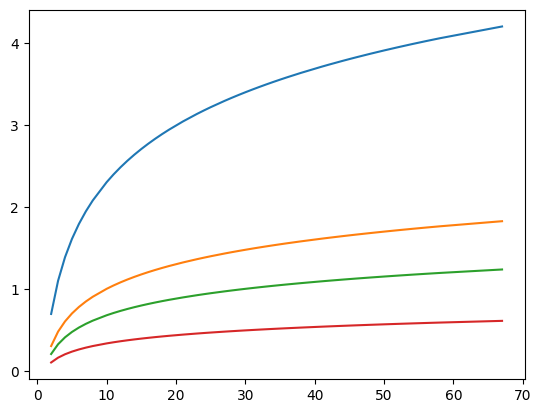

In [128]:
plt.plot(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False), np.log(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False)))
plt.plot(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False), np.log10(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False)))
plt.plot(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False), np.emath.logn(30, (kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False))))
plt.plot(kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False), np.emath.logn(1000, (kdf['matchesPlayed'].drop_duplicates().sort_values(ascending=False))))

### Other

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# ---------- Player stats ---------- #

players = pd.DataFrame(kills[['attackerName']])
players['attackerName'] = players['attackerName'].str.strip()
players = players.drop_duplicates(subset=['attackerName']).reset_index(drop=True).sort_values(by=['attackerName'])

# Matches played
kills['matches_played'] = kills.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['one'].transform('sum')
kill_test = kills.loc[kills['matches_played'].notna() == True].drop_duplicates(subset=['attackerName'])
players = players.merge(kill_test[['attackerName','matches_played']], on='attackerName', how='left')

# Kill count
kills['kill_count'] = kills.groupby(by=['attackerName'])['one'].transform('sum')
players = players.merge(kills[['attackerName','kill_count']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPM - kills per match
players['KPM'] = players['kill_count'] / players['matches_played']

# KPR - kills per round
rounds = kills[['matchID','roundNum']].sort_values(by=['matchID','roundNum']).drop_duplicates(subset=['matchID'],keep='last').rename(columns={'roundNum':'rounds_played'})
kills = kills.merge(rounds, on='matchID', how='left')
kills['KPM'] = kills[['attackerName','matchID','one']].groupby(by=['attackerName','matchID'])['one'].transform('sum')
kills['KPR_match'] = kills['KPM'] / kills['rounds_played']
kills['KPR'] = kills[['attackerName','KPR_match']].groupby(by=['attackerName'])['KPR_match'].transform('mean')
players = players.merge(kills[['attackerName','KPR']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted KPM
players['weighted_KPM'] = players['KPM'] * (players['matches_played'] / players['matches_played'].max())

# Headshot %
kills['hs_count'] = kills.groupby(by=['attackerName'])['isHeadshot'].transform('sum')
kills['HS%'] = kills['hs_count'] / kills['kill_count']
players = players.merge(kills[['attackerName','HS%']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted HS%
players['weighted_HS%'] = players['HS%'] * (players['matches_played'] / (players['matches_played'].max() - players['matches_played'].min()))

pd.set_option('display.max_rows', 100)
players.sort_values(by=['HS%'], ascending=False).head(5)